In [1]:
from cohirf.experiment.spherical_clustering import generate_spherical_clusters, visualize_3d_data
from cohirf.models.kernel_kmeans import KernelKMeans
from cohirf.models.batch_cohirf import BatchCoHiRF
from cohirf.models.cohirf import ModularCoHiRF
from cohirf.models.pseudo_kernel import PseudoKernelClustering
from ml_experiments.tuners import OptunaTuner
from ml_experiments.utils import unflatten_dict, update_recursively
from sklearn.metrics import adjusted_rand_score
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.cluster import KMeans
import optuna
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def training_fn(trial, model_cls, model_kwargs, features, true_labels):
    params = trial.params
    parsed_params = unflatten_dict(params)
    parsed_params = update_recursively(parsed_params, model_kwargs)
    model = model_cls(**parsed_params)
    labels = model.fit_predict(features)
    return adjusted_rand_score(true_labels, labels)

# Dataset

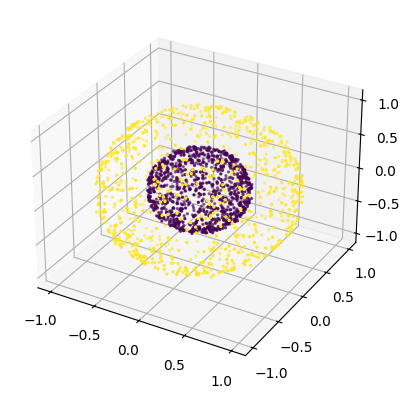

In [4]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01  # Standard deviation for the radii
seed_dataset = 42
n_samples = int(2e3)
n_samples_per_sphere = int(n_samples/2)  # Number of samples per sphere
features, true_labels = generate_spherical_clusters(
    mean_r, std, num_points_per_sphere=n_samples_per_sphere, seed=seed_dataset
)

visualize_3d_data(features, true_labels)

## Kernel KMeans

In [20]:
random_state_model = 42000
model_cls = KernelKMeans
search_space = {
    "gamma": optuna.distributions.FloatDistribution(0.1, 20),
}
model_kwargs = {
    "n_clusters": 2,
    "kernel": "rbf",
    "random_state": random_state_model,
}
training_fn = partial(
    training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features, true_labels=true_labels
)
tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 15:53:27,510] A new study created in memory with name: no-name-e693c09d-690b-44f2-a054-cea7099cdaf0


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
study.best_params, study.best_value

({'gamma': 17.33151535840103}, 0.2187437889178605)

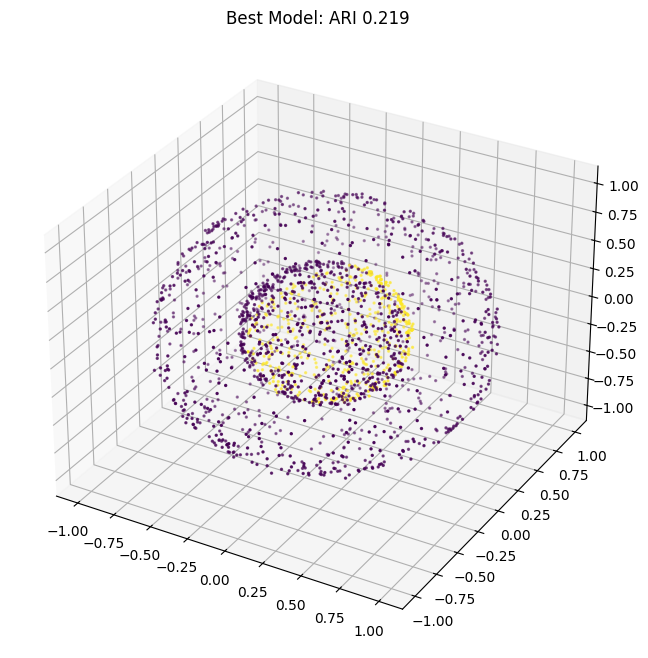

In [22]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## Pseudo Kernel KMeans

In [23]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2 ,'random_state': random_state_model},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500, 'random_state': random_state_model},
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 15:54:20,426] A new study created in memory with name: no-name-ed575ce1-b0b4-4a23-9f33-ee22cadc4ae3


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
study.best_params, study.best_value

({'transform_kwargs/gamma': 19.939919998571046}, 0.30002537718485467)

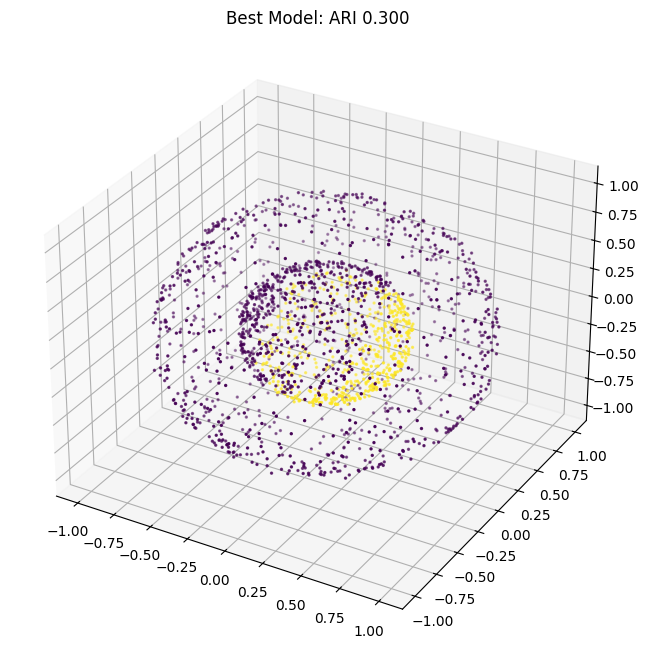

In [25]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## CoHiRF

In [5]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'n_features': optuna.distributions.IntDistribution(2, 3),
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 5),
    }
}
model_kwargs = {
    'base_model': KMeans,
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 16:02:45,235] A new study created in memory with name: no-name-9949cc25-48be-43c8-ae16-d0e53781e732


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
study.best_params, study.best_value

({'repetitions': 9, 'n_features': 2, 'base_model_kwargs/n_clusters': 5},
 0.007332736512078745)

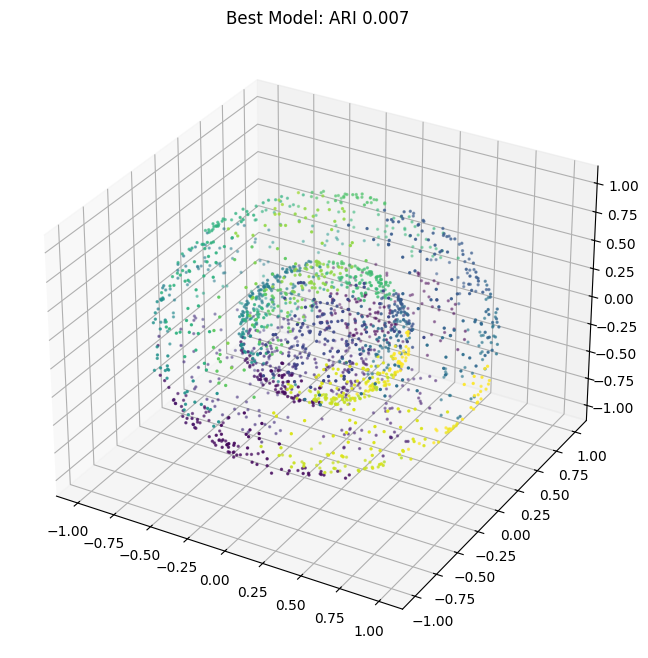

In [7]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## Kernel CoHiRF

In [25]:
model = ModularCoHiRF(
    base_model=KernelKMeans,
    base_model_kwargs={'n_clusters': 4, 'kernel': 'rbf', 'gamma': 6},
    repetitions=3,
    n_features=2,
    random_state=random_state_model
)
labels = model.fit_predict(features)

In [29]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 5),
    },
}
model_kwargs = {
    'representative_method': 'rbf',
    'n_features': 2,
    'base_model': KernelKMeans,
    'base_model_kwargs': {'kernel': 'rbf'},
    'random_state': random_state_model,
    'verbose': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 16:21:27,220] A new study created in memory with name: no-name-e5bbd77f-fd73-447e-a839-cebefd1129fb


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

Starting fit
Iteration 0
Starting consensus assignment
Starting repetition 0
Starting repetition 1
Starting repetition 2
Choosing new representative sample for cluster 0
Computing similarities with method rbf
Choosing new representative sample for cluster 1
Computing similarities with method rbf
Choosing new representative sample for cluster 2
Computing similarities with method rbf
Choosing new representative sample for cluster 3
Computing similarities with method rbf
Choosing new representative sample for cluster 4
Computing similarities with method rbf
Choosing new representative sample for cluster 5
Computing similarities with method rbf
Choosing new representative sample for cluster 6
Computing similarities with method rbf
Choosing new representative sample for cluster 7
Computing similarities with method rbf
Choosing new representative sample for cluster 8
Computing similarities with method rbf
Choosing new representative sample for cluster 9
Computing similarities with method rbf

ValueError: n_samples=1 should be >= n_clusters=4

## Approx. Kernel CoHiRF

In [13]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    "repetitions": optuna.distributions.IntDistribution(2, 10),
    "transform_kwargs": {
        "gamma": optuna.distributions.FloatDistribution(0.1, 30),
    },
    "base_model_kwargs": {
        "n_clusters": optuna.distributions.IntDistribution(2, 5),
    },
}
model_kwargs = {
    "n_features": 2,
    "representative_method": "rbf",
    "base_model": KMeans,
    "transform_method": RBFSampler,
    "transform_kwargs": {"n_components": 500},
    "random_state": random_state_model,
}
training_fn = partial(
    training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features, true_labels=true_labels
)
tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 16:07:39,735] A new study created in memory with name: no-name-3ccc55d8-8831-47ac-8534-b1846e89dd12


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
study.best_params, study.best_value

({'repetitions': 3,
  'transform_kwargs/gamma': 15.866974014136561,
  'base_model_kwargs/n_clusters': 3},
 0.15476625326778867)

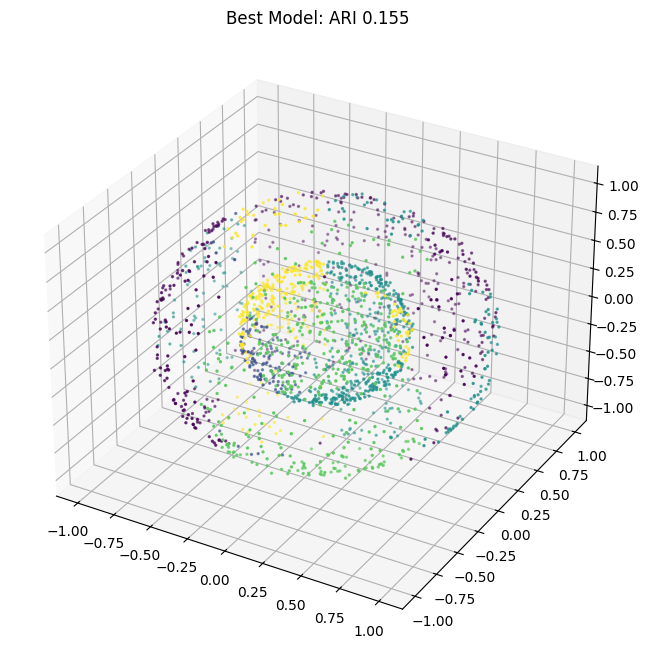

In [15]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

# Dataset with radius

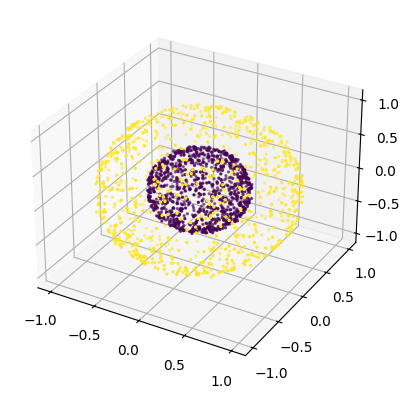

In [4]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01  # Standard deviation for the radii
seed_dataset = 42
n_samples = int(2e3)
n_samples_per_sphere = int(n_samples / 2)  # Number of samples per sphere
features, true_labels = generate_spherical_clusters(
    mean_r, std, num_points_per_sphere=n_samples_per_sphere, seed=seed_dataset
)
visualize_3d_data(features, true_labels)
features = np.hstack((features, np.sum(features**2, axis=1, keepdims=True)))

## KMeans

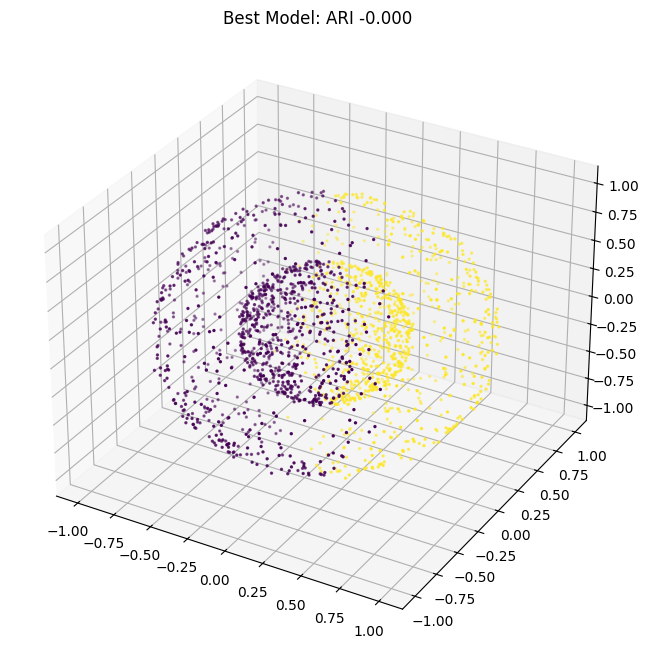

In [8]:
random_state_model = 42000
model = KMeans(n_clusters=2, random_state=random_state_model)
labels = model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## Approx. Kernel KMeans

In [9]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    "transform_kwargs": {
        "gamma": optuna.distributions.FloatDistribution(0.1, 20),
    },
}
model_kwargs = {
    "base_model": KMeans,
    "base_model_kwargs": {"n_clusters": 2, "random_state": random_state_model},
    "transform_method": RBFSampler,
    "transform_kwargs": {"n_components": 500, "random_state": random_state_model},
}
training_fn_model = partial(
    training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features, true_labels=true_labels
)
tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 16:57:58,199] A new study created in memory with name: no-name-97408f24-4148-4d1f-9703-ba8f24b77936


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
study.best_params, study.best_value

({'transform_kwargs/gamma': 2.435332138564481}, 1.0)

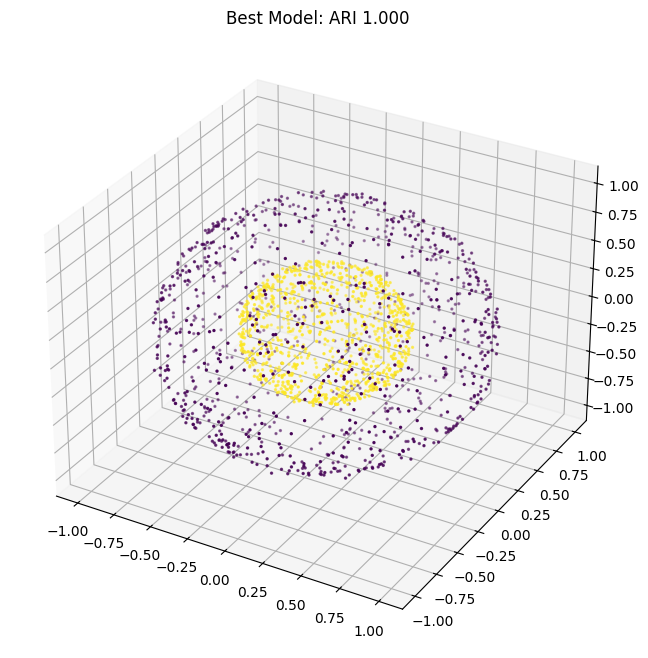

In [11]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## CoHiRF KMeans

In [15]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 5),
    },
    'n_features': optuna.distributions.IntDistribution(2, 4),
}
model_kwargs = {
    'representative_method': 'closest_overall',
    'base_model': KMeans,
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn_model = partial(
    training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features, true_labels=true_labels
)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 16:59:08,583] A new study created in memory with name: no-name-20772b3f-a204-4504-9780-226edcba7d16


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
study.best_params, study.best_value

({'repetitions': 2, 'base_model_kwargs/n_clusters': 4, 'n_features': 3},
 0.6327708773728912)

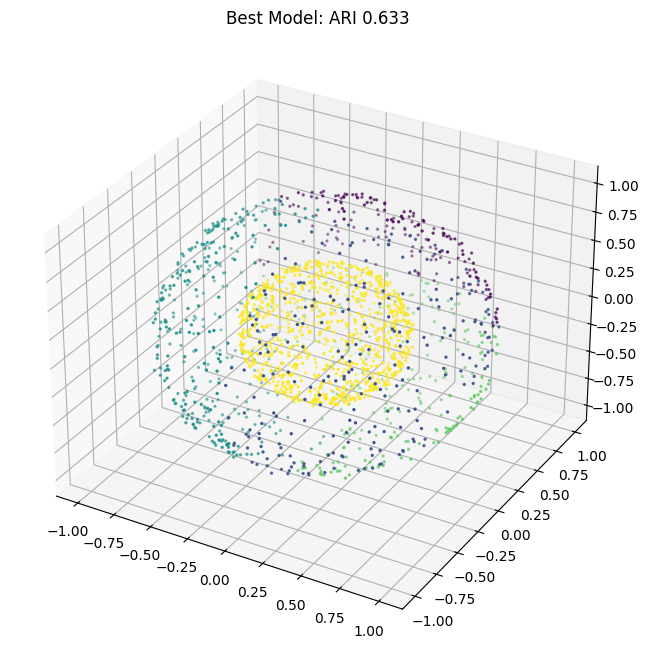

In [17]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## CoHiRF Approx. Kernel KMeans

In [5]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 5),
    },
    'n_features': optuna.distributions.IntDistribution(2, 4),
}
model_kwargs = {
    'representative_method': 'rbf',
    'base_model': KMeans,
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn_model = partial(
    training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features, true_labels=true_labels
)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 17:00:49,082] A new study created in memory with name: no-name-890a31ab-1f91-4fa5-b521-2dd9df075c87


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
best_params_cohirf_approx_kernel = study.best_params

In [6]:
study.best_params, study.best_value

({'repetitions': 4,
  'transform_kwargs/gamma': 2.3917810246183047,
  'base_model_kwargs/n_clusters': 2,
  'n_features': 4},
 1.0)

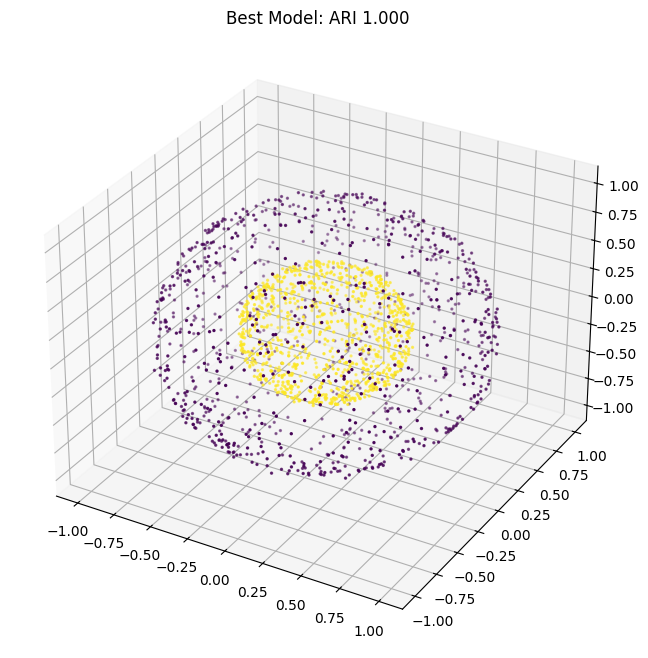

In [7]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## Batch CoHiRF KMeans Optimization All

In [14]:
random_state_model = 42000
model_cls = BatchCoHiRF
search_space = {
    "cohirf_kwargs": {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        "n_features": optuna.distributions.IntDistribution(2, 4),
        "base_model_kwargs": {
            "n_clusters": optuna.distributions.IntDistribution(2, 5),
        }
    },
}
model_kwargs = {
    "cohirf_model": ModularCoHiRF,
    "cohirf_kwargs": dict(base_model=KMeans, random_state=random_state_model, max_iter=1),
    "batch_size": int(5e2),
}
training_fn_model = partial(
    training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features, true_labels=true_labels
)
tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 17:07:18,738] A new study created in memory with name: no-name-b38e4e96-17aa-47d8-9cfd-9739cf00448b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
study.best_params, study.best_value

({'cohirf_kwargs/repetitions': 2,
  'cohirf_kwargs/n_features': 4,
  'cohirf_kwargs/base_model_kwargs/n_clusters': 5},
 0.47909384937693866)

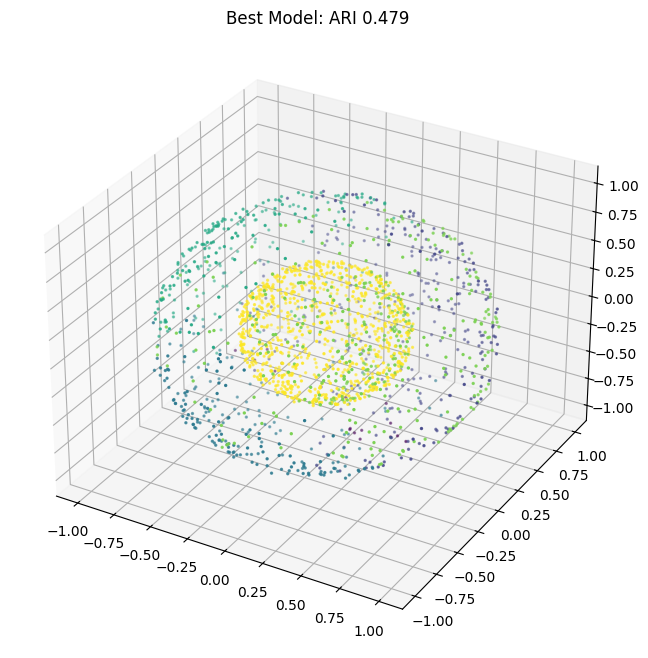

In [16]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## Batch CoHiRF KMeans Optimization first batch

In [19]:
random_state_model = 42000
batch_size = int(5e2)
model_cls = BatchCoHiRF
search_space = {
    "cohirf_kwargs": {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        "n_features": optuna.distributions.IntDistribution(2, 4),
        "base_model_kwargs": {
            "n_clusters": optuna.distributions.IntDistribution(2, 5),
        },
    },
}
model_kwargs = {
    "cohirf_model": ModularCoHiRF,
    "cohirf_kwargs": dict(base_model=KMeans, random_state=random_state_model, max_iter=1),
    "batch_size": batch_size,
}
features_first_batch = features[:batch_size]
true_labels_first_batch = true_labels[:batch_size]
training_fn_model = partial(
    training_fn,
    model_cls=model_cls,
    model_kwargs=model_kwargs,
    features=features_first_batch,
    true_labels=true_labels_first_batch,
)
tuner = OptunaTuner(sampler="tpe", n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 17:09:14,906] A new study created in memory with name: no-name-8d4e5657-4918-4985-969b-c8e691d84a34


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
study.best_params, study.best_value

({'cohirf_kwargs/repetitions': 2,
  'cohirf_kwargs/n_features': 4,
  'cohirf_kwargs/base_model_kwargs/n_clusters': 4},
 0.6873043497131058)

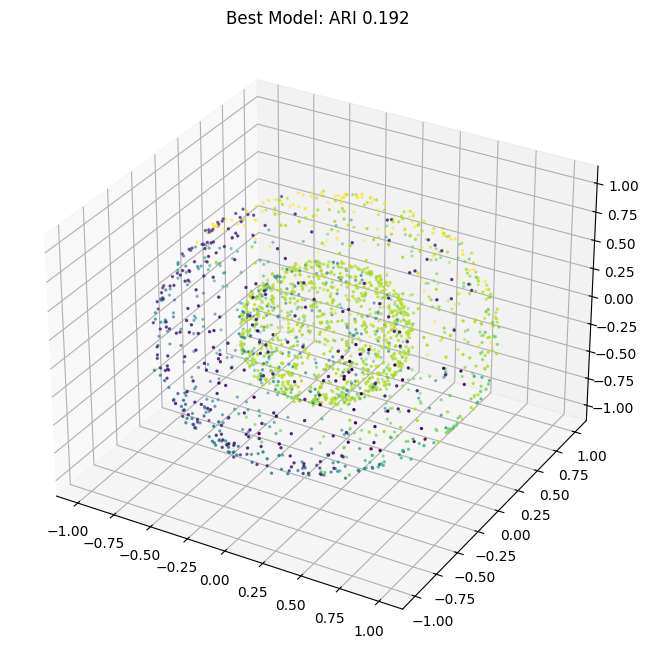

In [21]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## Batch CoHiRF Approx. Kernel KMeans Optimization All

In [23]:
random_state_model = 42000
batch_size = int(5e2)
model_cls = BatchCoHiRF
search_space = {
    "cohirf_kwargs": {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        "n_features": optuna.distributions.IntDistribution(2, 4),
        "base_model_kwargs": {
            "n_clusters": optuna.distributions.IntDistribution(2, 5),
        },
        "transform_kwargs": {
            "gamma": optuna.distributions.FloatDistribution(0.1, 30),
        },
    },
}
model_kwargs = {
    "cohirf_model": ModularCoHiRF,
    "cohirf_kwargs": dict(
        base_model=KMeans,
        transform_method=RBFSampler,
        transform_kwargs={"n_components": 500},
        representative_method="rbf",
        random_state=random_state_model,
    ),
    "batch_size": batch_size,
}
training_fn_model = partial(
    training_fn,
    model_cls=model_cls,
    model_kwargs=model_kwargs,
    features=features,
    true_labels=true_labels,
)
tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 17:11:31,974] A new study created in memory with name: no-name-dd592ca0-84ad-47c6-a320-b4677996e35d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
study.best_params, study.best_value

({'cohirf_kwargs/repetitions': 4,
  'cohirf_kwargs/n_features': 4,
  'cohirf_kwargs/base_model_kwargs/n_clusters': 2,
  'cohirf_kwargs/transform_kwargs/gamma': 3.5237606222306765},
 0.4853402103074566)

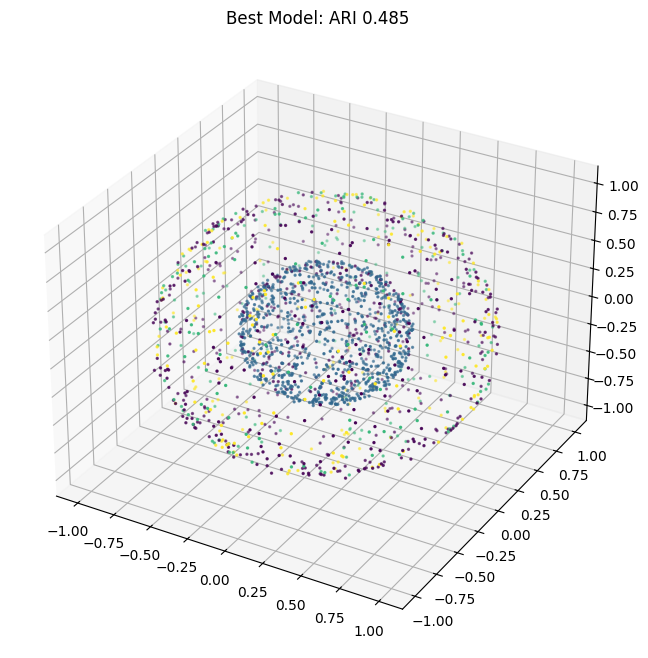

In [25]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()

## Batch CoHiRF Approx. Kernel KMeans Optimization first batch

In [26]:
random_state_model = 42000
batch_size = int(5e2)
model_cls = BatchCoHiRF
search_space = {
    "cohirf_kwargs": {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        "n_features": optuna.distributions.IntDistribution(2, 4),
        "base_model_kwargs": {
            "n_clusters": optuna.distributions.IntDistribution(2, 5),
        },
        "transform_kwargs": {
            "gamma": optuna.distributions.FloatDistribution(0.1, 30),
        },
    },
}
model_kwargs = {
    "cohirf_model": ModularCoHiRF,
    "cohirf_kwargs": dict(
        base_model=KMeans,
        transform_method=RBFSampler,
        transform_kwargs={"n_components": 500},
        representative_method="rbf",
        random_state=random_state_model,
    ),
    "batch_size": batch_size,
}
first_batch_features = features[:batch_size]
first_batch_true_labels = true_labels[:batch_size]
training_fn_model = partial(
    training_fn,
    model_cls=model_cls,
    model_kwargs=model_kwargs,
    features=first_batch_features,
    true_labels=first_batch_true_labels,
)
tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-27 17:12:34,903] A new study created in memory with name: no-name-7220f690-23aa-400e-9880-5393bac4dbe8


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
study.best_params, study.best_value

({'cohirf_kwargs/repetitions': 2,
  'cohirf_kwargs/n_features': 3,
  'cohirf_kwargs/base_model_kwargs/n_clusters': 2,
  'cohirf_kwargs/transform_kwargs/gamma': 0.9780297445253519},
 1.0)

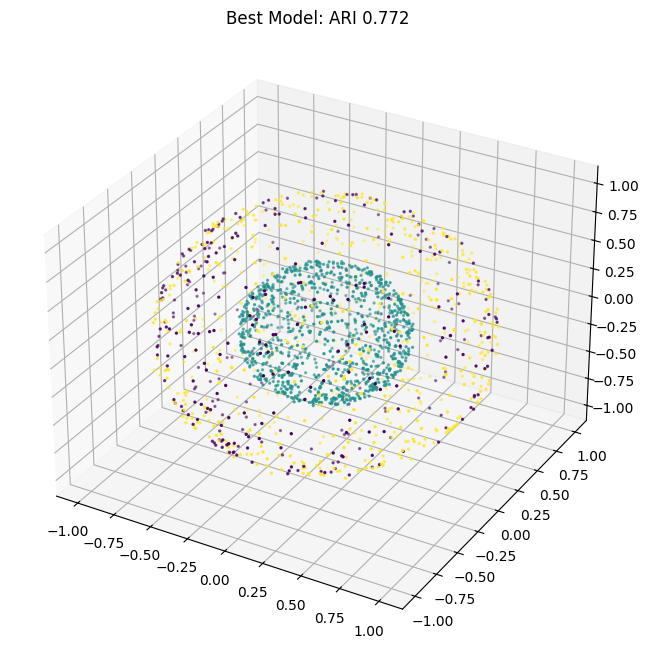

In [28]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="viridis", s=2)
ax.set_title(f"Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}")
plt.show()